# **How to Use the Data Scripts and the Forecasting Tool?**

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

from data_scripts.data_loader import download_latest_bpa_and_usgs_data
from data_scripts.discharge_file_processor import process_discharge_file
from data_scripts.scaling_ratio_file_processor import process_scaling_ratio_file
from data_scripts.hydro_generation_file_processor import process_hydro_generation_file
from forecasting_tool.forecasting_tool import ForecastingTool

## **Data Scripts**

### **Download Latest BPA and USGS Data**

This function downloads the latest BPA Hydropower generation and USGS discharge data into their respective folders

In [2]:
download_latest_bpa_and_usgs_data()

2025-02-26 04:55:17,179 - INFO - File downloaded successfully: ../bpa_data/WindGenTotalLoadYTD_2025.xlsx
2025-02-26 04:55:28,869 - INFO - File downloaded successfully: ../uscs_data/discharge_data.txt


### **Process Scaling Ratio**

This function processes USACE data to extract the scaling ratio and total monthly generation for Columbia River projects, and stores in `training_data/usace_columbia_projects_data`. The scaling ratio represents the proportion of total monthly generation attributed to Columbia River projects.

In [3]:
process_scaling_ratio_file()

2025-02-26 05:00:57,198 - WARNING - Missing data file: ../usace_data/pwr_202502.txt, using previous scaling ratio.
2025-02-26 05:00:57,282 - INFO - Processed data saved to ../training_data/usace_columbia_projects_data.csv


### **Process Hydropower Generation Data**

This function reads BPA data files, calculates the Columbia River hydropower generation using the extracted scaling ratio, and merges and stores the results in `training_data/columbia_hydro_generation_data_{H/D}`.

In [8]:
process_hydro_generation_file('D')  # 'H' for hourly and 'D' for daily

2025-02-26 05:23:39,787 - INFO - Processing file: ../bpa_data/WindGenTotalLoadYTD_2023.xlsx
2025-02-26 05:23:45,583 - INFO - Processing file: ../bpa_data/WindGenTotalLoadYTD_2024.xlsx
2025-02-26 05:23:50,685 - INFO - Processing file: ../bpa_data/WindGenTotalLoadYTD_2025.xlsx
2025-02-26 05:23:51,452 - INFO - Processed data saved to ../training_data/columbia_hydro_generation_data_D.csv


### **Process Discharge Data**

This function reads USCS discharge data file for The Dalles and stores the resampled results in `training_data/uscs_dalles_discharge_data_{H/D}`.

In [7]:
process_discharge_file('H') # 'H' for hourly and 'D' for daily

/Users/snehil1998/Documents/Repos/hydro-generaton-forecast/data_scripts/discharge_file_processor.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample(resampling_interval).mean()
2025-02-26 05:23:23,563 - INFO - Processed discharge data saved to ../training_data/uscs_dalles_discharge_data_H.csv


## **The Forecasting Tool**

### **Model Evaluation**
 
The forecasting tool can be used in evaluation mode, where it trains the model using a train-test split, generates a plot comparing actual and predicted test data, and returns evaluation metrics such as RMSE and MAE.

2025-02-26 07:27:51,466 - INFO - Loading datasets...
2025-02-26 07:27:51,519 - INFO - Starting training pipeline...
2025-02-26 07:27:51,519 - INFO - Creating features...
2025-02-26 07:27:51,524 - INFO - Splitting data for evaluation...
2025-02-26 07:27:51,527 - INFO - Training XGBoost model...


[0]	validation_0-rmse:1871.58553
[100]	validation_0-rmse:1156.55968
[200]	validation_0-rmse:881.52929
[300]	validation_0-rmse:737.99586
[400]	validation_0-rmse:675.75482
[499]	validation_0-rmse:638.46910


2025-02-26 07:27:52,192 - INFO - Model training completed (not saved for evaluation).
2025-02-26 07:27:52,192 - INFO - Evaluating model...


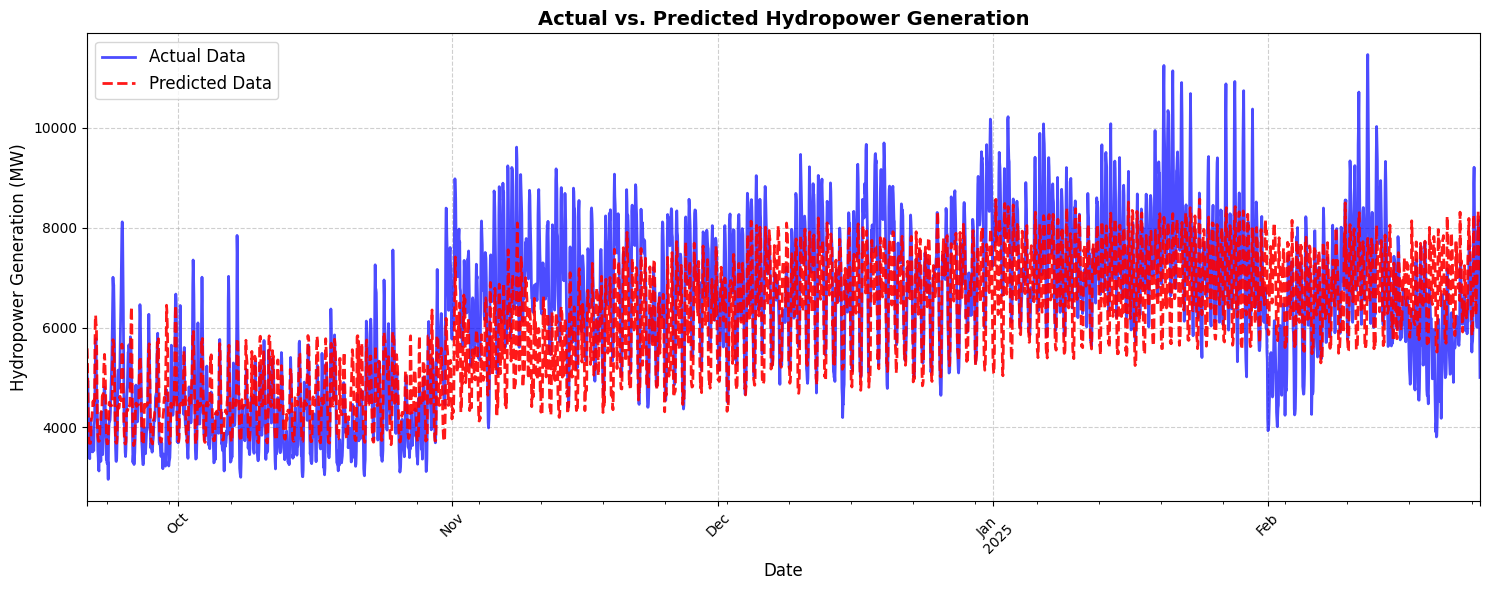

{'RMSE: 993.06, MAE: 780.80'}

In [2]:
tool = ForecastingTool(test_size=0.2, enable_evaluation=True)
tool.train(n_estimators=500, learning_rate=0.01, early_stopping_rounds=50)

### **Forecasting**

In forecasting mode, the tool trains the model on the entire dataset and saves it as hydropower_xgb.pkl. The forecast() function then loads the saved model, generates predictions for the specified number of days, saves the forecasted results as a CSV, and displays both hourly and daily plots.

In [2]:
tool = ForecastingTool(enable_evaluation=False)
tool.train()

2025-02-26 07:31:25,388 - INFO - Loading datasets...
2025-02-26 07:31:25,421 - INFO - Starting training pipeline...
2025-02-26 07:31:25,422 - INFO - Creating features...
2025-02-26 07:31:25,425 - INFO - Training on full dataset (no test set)...
2025-02-26 07:31:25,425 - INFO - Training XGBoost model...
2025-02-26 07:31:26,132 - INFO - Model saved at ../forecasting_tool/hydropower_xgb.pkl


2025-02-26 07:31:50,249 - INFO - Forecasting 30 days into the future...
2025-02-26 07:31:50,306 - INFO - Model loaded from ../forecasting_tool/hydropower_xgb.pkl
/Users/snehil1998/Documents/Repos/hydro-generaton-forecast/forecasting_tool/forecasting_tool.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_df = pd.DataFrame(index=pd.date_range(start=last_datetime + timedelta(hours=1), periods=future_steps, freq='H'))
2025-02-26 07:31:50,316 - INFO - Creating features...
2025-02-26 07:31:50,338 - INFO - Forecasting completed.


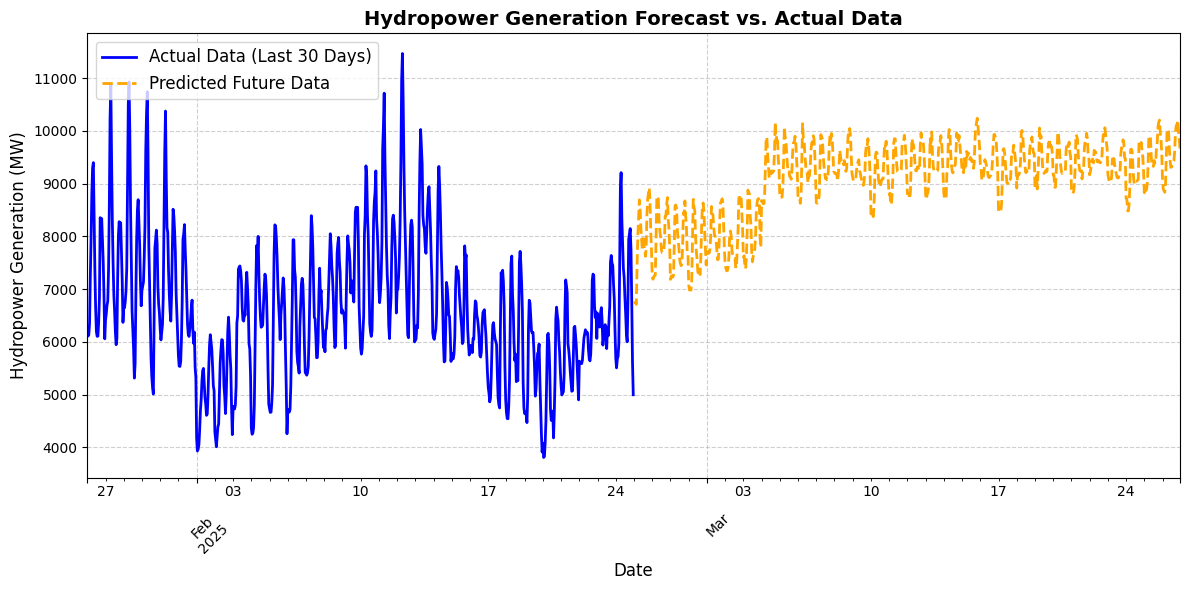

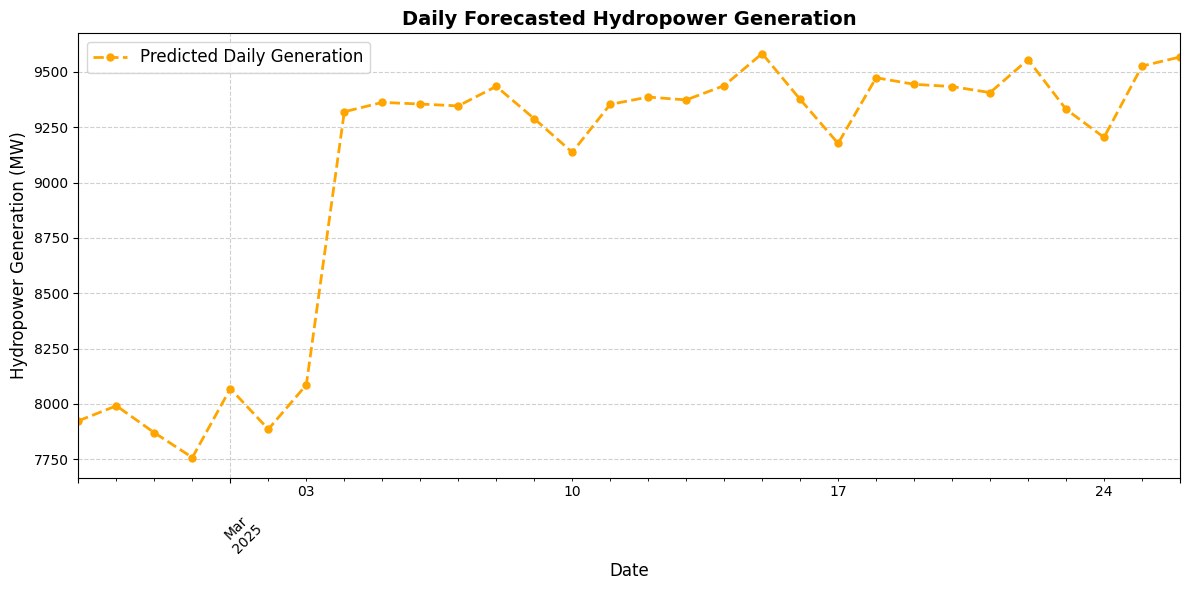

In [3]:
tool.forecast(days=30)